In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [3]:
image_size = (256, 256)
hydro_dir = r"C:\Users\nishi\EPICS\mmflood\mmflood\output\Hydro_Standardized"
dem_dir = r"C:\Users\nishi\EPICS\mmflood\mmflood\output\DEM_Standardized"
s1_raw_dir = r"C:\Users\nishi\EPICS\mmflood\mmflood\output\S1_RGB_Img_Standardized"
mask_dir = r"C:\Users\nishi\EPICS\mmflood\mmflood\output\Mask_Standardized"

In [4]:
hydro_files = sorted(os.listdir(hydro_dir))
dem_files = sorted(os.listdir(dem_dir))
s1_raw_files = sorted(os.listdir(s1_raw_dir))
mask_files = sorted(os.listdir(mask_dir))

common_files = set(hydro_files) & set(dem_files) & set(s1_raw_files) & set(mask_files)
common_files = sorted(list(common_files))

In [5]:
def load_common_images(image_paths, common_files):
    images = []
    for file in common_files:
        img_path = os.path.join(image_paths, file)
        img = load_img(img_path, target_size=image_size)
        img = img_to_array(img) / 255.0
        images.append(img)
    return np.array(images)

In [6]:
hydro_data = load_common_images(hydro_dir, common_files)
dem_data = load_common_images(dem_dir, common_files)
s1_raw_data = load_common_images(s1_raw_dir, common_files)
mask_data = load_common_images(mask_dir, common_files)

In [7]:
mask_data = (mask_data > 0.5).astype(np.uint8)

In [8]:
X = np.concatenate([hydro_data, dem_data, s1_raw_data], axis=-1)
y = mask_data

In [9]:
print(f"Hydro Data Shape: {hydro_data.shape}")
print(f"DEM Data Shape: {dem_data.shape}")
print(f"S1 Raw Data Shape: {s1_raw_data.shape}")
print(f"Mask Data Shape: {mask_data.shape}")
print(f"Final Input Shape (X): {X.shape}")

Hydro Data Shape: (1012, 256, 256, 3)
DEM Data Shape: (1012, 256, 256, 3)
S1 Raw Data Shape: (1012, 256, 256, 3)
Mask Data Shape: (1012, 256, 256, 3)
Final Input Shape (X): (1012, 256, 256, 9)


In [10]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=176)
print(f"Training Data Shape: {X_train.shape}, Validation Data Shape: {X_val.shape}")

Training Data Shape: (809, 256, 256, 9), Validation Data Shape: (203, 256, 256, 9)


In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate, Input
from tensorflow.keras.models import Model

In [12]:
def unet_model(input_size=(256, 256, 9)):  
    inputs = Input(input_size)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    up1 = UpSampling2D(size=(2, 2))(conv3)
    merge1 = concatenate([conv2, up1], axis=-1)
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(merge1)
    up2 = UpSampling2D(size=(2, 2))(conv4)
    merge2 = concatenate([conv1, up2], axis=-1)
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(merge2)
    output = Conv2D(1, (1, 1), activation='sigmoid')(conv5)  # Binary mask
    model = Model(inputs, output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model
model = unet_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 256, 256, 9)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d (Conv2D)               │ (None, 256, 256, 64)      │           5,248 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d (MaxPooling2D)  │ (None, 128, 128, 64)      │               0 │ conv2d[0][0]               │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_1 (Conv2D)             │ (None, 128, 128, 128)     │          73,856 │ max_pooling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ max_pooling2d_1               │ (None, 64, 64, 128)       │               0 │ conv2d_1[0][0]             │
│ (MaxPooling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_2 (Conv2D)             │ (None, 64, 64, 256)       │         295,168 │ max_pooling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d (UpSampling2D)  │ (None, 128, 128, 256)     │               0 │ conv2d_2[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate (Concatenate)     │ (None, 128, 128, 384)     │               0 │ conv2d_1[0][0],            │
│                               │                           │                 │ up_sampling2d[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_3 (Conv2D)             │ (None, 128, 128, 128)     │         442,496 │ concatenate[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ up_sampling2d_1               │ (None, 256, 256, 128)     │               0 │ conv2d_3[0][0]             │
│ (UpSampling2D)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 256, 256, 192)     │               0 │ conv2d[0][0],              │
│                               │                           │                 │ up_sampling2d_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_4 (Conv2D)             │ (None, 256, 256, 64)      │         110,656 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_5 (Conv2D)             │ (None, 256, 256, 1)       │              65 │ conv2d_4[0][0]             │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 927,489 (3.54 MB)

 Trainable params: 927,489 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
y_train = y_train[..., :1]  
y_val = y_val[..., :1]

In [14]:
batch_size = 2
epochs = 10

In [15]:
def train_generator(X, Y, batch_size):
    while True:  
        for i in range(0, len(X), batch_size):
            X_batch = X[i:i+batch_size]
            Y_batch = Y[i:i+batch_size]
            yield X_batch, Y_batch  

In [16]:
history = model.fit(train_generator(X_train, y_train, batch_size=batch_size), validation_data=(X_val, y_val),
                    steps_per_epoch=len(X_train) // batch_size, epochs=10) 
# 101 passes and 50 epochs

Epoch 1/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 388s 956ms/step - accuracy: 0.8835 - loss: 0.2880 - val_accuracy: 0.9467 - val_loss: 0.1631
Epoch 2/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 379s 939ms/step - accuracy: 0.9298 - loss: 0.2095 - val_accuracy: 0.9507 - val_loss: 0.1577
Epoch 3/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 358s 885ms/step - accuracy: 0.9302 - loss: 0.2030 - val_accuracy: 0.9515 - val_loss: 0.1540
Epoch 4/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 353s 873ms/step - accuracy: 0.9293 - loss: 0.2020 - val_accuracy: 0.9489 - val_loss: 0.1556
Epoch 5/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 461s 1s/step - accuracy: 0.9294 - loss: 0.2131 - val_accuracy: 0.9494 - val_loss: 0.1571
Epoch 6/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 337s 833ms/step - accuracy: 0.9504 - loss: 0.1588 - val_accuracy: 0.9539 - val_loss: 0.1445
Epoch 7/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 338s 837ms/step - accuracy: 0.9477 - loss: 0.1586 - val_accuracy: 0.9539 - val_loss: 0.1473
Epoch 8/10
404/404 ━━━━━━━━━━━━━━━━━━━━ 329s 815ms/step - accuracy: 0.9425 - lo

In [18]:
model.save_weights("newts.weights.h5")


In [28]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get model predictions (binary thresholding at 0.5)
y_pred = model.predict(X_val)
y_pred_bin = (y_pred > 0.5).astype(np.uint8)

# If y_val is one-hot encoded or has extra dims
if y_val.ndim > 1:
    y_val_flat = y_val.flatten()
    y_pred_flat = y_pred_bin.flatten()
else:
    y_val_flat = y_val
    y_pred_flat = y_pred_bin


7/7 ━━━━━━━━━━━━━━━━━━━━ 47s 5s/step


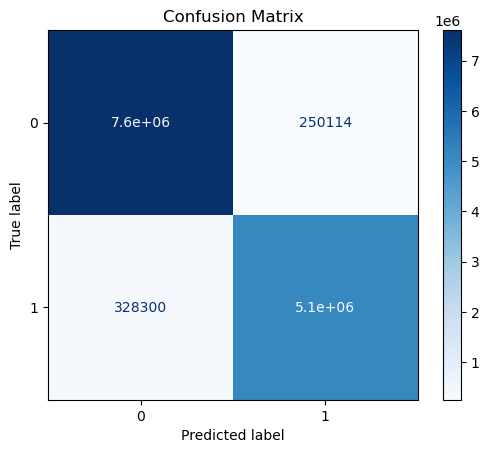

In [29]:
import matplotlib.pyplot as plt

# Compute and plot confusion matrix
cm = confusion_matrix(y_val_flat, y_pred_flat)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [30]:
# from sklearn.metrics import f1_score

# y_pred = model.predict(X_val)
# y_pred_bin = (y_pred > 0.5).astype(int)

# y_true = y_val.flatten()
# y_pred_flat = y_pred_bin.flatten()

# f1 = f1_score(y_true, y_pred_flat)
# print("F1 Score:", f1)

7/7 ━━━━━━━━━━━━━━━━━━━━ 52s 6s/step
F1 Score: 0.9465139280500287


In [31]:
# from sklearn.metrics import precision_score

# y_pred = model.predict(X_val)
# y_pred_bin = (y_pred > 0.5).astype(int)

# y_true = y_val.flatten()
# y_pred_flat = y_pred_bin.flatten()

# precision = precision_score(y_true, y_pred_flat)
# print("Precision:", precision)

7/7 ━━━━━━━━━━━━━━━━━━━━ 34s 4s/step
Precision: 0.9534069428897218


In [32]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_true, y_pred_flat)
recall = recall_score(y_true, y_pred_flat)
f1 = f1_score(y_true, y_pred_flat)

print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Precision: 0.9534
Recall:    0.9397
F1 Score:  0.9465


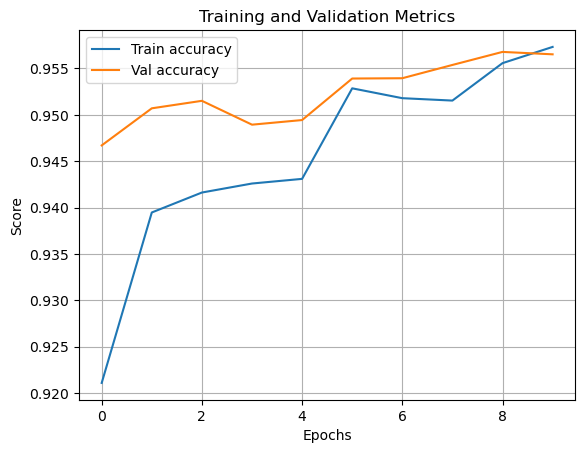

In [33]:
import matplotlib.pyplot as plt

def plot_metrics(history):
    metrics = ['accuracy', 'precision', 'recall', 'f1_score']
    
    for metric in metrics:
        if metric in history.history:
            plt.plot(history.history[metric], label=f'Train {metric}')
        if f'val_{metric}' in history.history:
            plt.plot(history.history[f'val_{metric}'], label=f'Val {metric}')
    
    plt.title('Training and Validation Metrics')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_metrics(history)